In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
subjects = ace.list_subjects(root_directory)
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'

In [3]:
# Take the SW > 19
subjects = [sub for sub in subjects if sub[0:2]=='SW' and int(sub[2:].split('_')[0]) in set(range(19,36))]

In [4]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [5]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

# Analysis on SWISS 19-35 with father : threshold 300

In [9]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results_across_mice_SW19-35-200.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
dict_results_across_mice = np.load('dict_results_across_mice_SW19-35-200.npy', allow_pickle=True).item()

# List areas with null cell count

In [11]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [12]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [13]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['SW25_Control',
  'SW19_Control',
  'SW24_Control',
  'SW31_Control',
  'SW30_Control'],
 'Unfam': ['SW26_Unfam',
  'SW20_Unfam',
  'SW22_Unfam',
  'SW28_Unfam',
  'SW34_Unfam',
  'SW32_Unfam'],
 'Fam': ['SW27_Fam',
  'SW23_Fam',
  'SW21_Fam',
  'SW29_Fam',
  'SW33_Fam',
  'SW35_Fam']}

# Calculate cell count across experimental groups

In [14]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

## Calculate t-tests across groups per area

In [15]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.200472,0.754138,0.163928
1,Primary motor area,0.316072,0.777099,0.335878
2,Secondary motor area,0.393013,0.993481,0.212957
3,Primary somatosensory area,0.18637,0.552591,0.156595
4,Supplemental somatosensory area,0.146731,0.659916,0.119205
...,...,...,...,...
293,Flocculus,0.343954,0.825016,0.0694456
294,Fastigial nucleus,0.483679,0.113753,0.173948
295,Interposed nucleus,0.990644,0.137905,0.37049
296,Dentate nucleus,0.914665,0.160558,0.490982


In [16]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [48]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,0.000122907
Medial amygdalar nucleus,0.000928805
Ventral premammillary nucleus,0.00566085
Vascular organ of the lamina terminalis,0.0362495
Posterior limiting nucleus of the thalamus,0.0532769
Central amygdalar nucleus,0.0630629
Parastrial nucleus,0.0650028
Cortical amygdalar area,0.0680162
Anterior tegmental nucleus,0.0684783


In [18]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,0.000579061
Posterior amygdalar nucleus,0.000952831
Ventral premammillary nucleus,0.00170265
Accessory olfactory bulb,0.0132093
Bed nucleus of the anterior commissure,0.0163697
Piriform-amygdalar area,0.0320793
Septohippocampal nucleus,0.0353659
Copula pyramidis,0.0361345
Tuberal nucleus,0.0376705


In [19]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nucleus of the anterior commissure,0.00314843
Paraventricular hypothalamic nucleus descending division,0.0115384
Dorsal auditory area,0.0299272
Septohippocampal nucleus,0.0330957
Caudoputamen,0.0368437
Posterior hypothalamic nucleus,0.0386065
Superior colliculus sensory related,0.0424097
Laterodorsal tegmental nucleus,0.0455417
Subparafascicular area,0.049805


## Mann Whitney Test for comparison across groups

In [20]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.117667,0.463632,0.0641026
1,Primary motor area,0.117667,0.463632,0.114883
2,Secondary motor area,0.261408,0.463632,0.0867427
3,Primary somatosensory area,0.0854518,0.463632,0.114883
4,Supplemental somatosensory area,0.0854518,0.463632,0.0867427
...,...,...,...,...
293,Flocculus,0.323664,0.323664,0.0388242
294,Fastigial nucleus,0.335704,0.0681901,0.0878672
295,Interposed nucleus,0.285219,0.0729127,0.295685
296,Dentate nucleus,0.0811374,0.0873154,0.376277


In [21]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [22]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,0.00405656
Medial amygdalar nucleus,0.00405656
Cortical amygdalar area,0.0276171
Ventral premammillary nucleus,0.033632
Vascular organ of the lamina terminalis,0.0344472
Globus pallidus internal segment,0.0407199
Caudoputamen,0.0414187
Visceral area,0.0414187
Posterior limiting nucleus of the thalamus,0.0447458


In [23]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,0.00405656
Posterior amygdalar nucleus,0.00405656
Ventral premammillary nucleus,0.00405656
Accessory olfactory bulb,0.00685542
Bed nucleus of the anterior commissure,0.00820708
Tuberal nucleus,0.0112394
Magnocellular reticular nucleus,0.0112394
Copula pyramidis,0.011615
Parapyramidal nucleus,0.0122943


In [52]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:35].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nucleus of the anterior commissure,0.00435301
Paraventricular hypothalamic nucleus descending division,0.0121093
Nucleus raphe pallidus,0.0142203
Triangular nucleus of septum,0.0224756
Piriform area,0.0226638
Posterior hypothalamic nucleus,0.0226638
Superior colliculus sensory related,0.0226638
Dorsal auditory area,0.0271206
Septohippocampal nucleus,0.0301236


## Calculate cross corr across groups per area on cell count

In [25]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

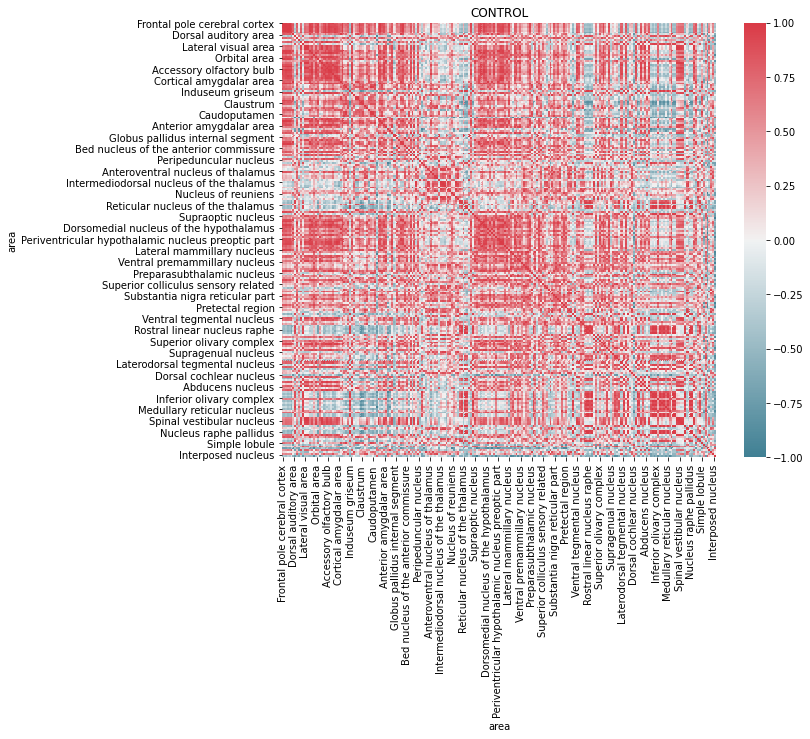

In [26]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

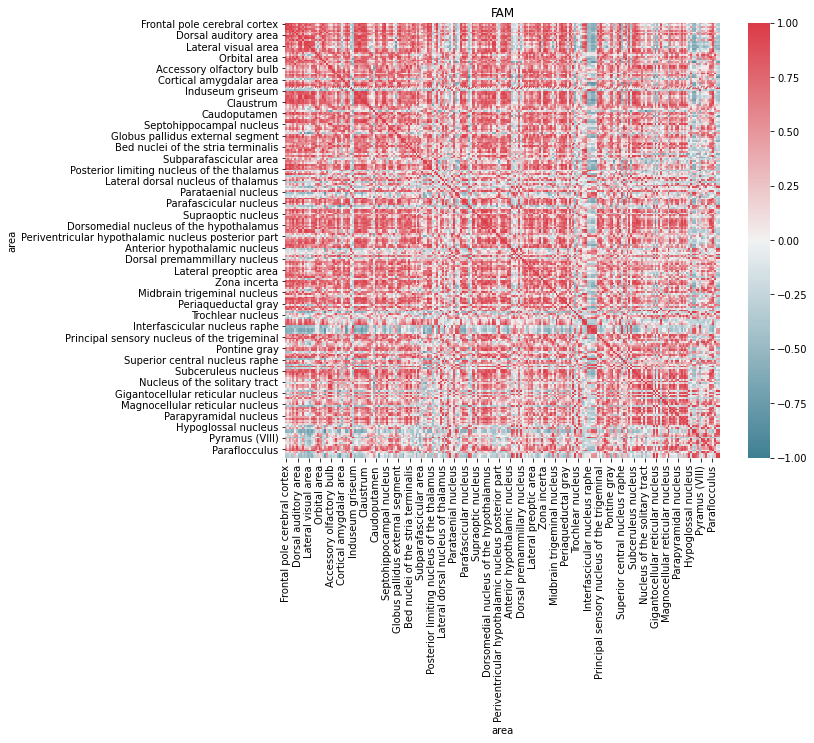

In [27]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

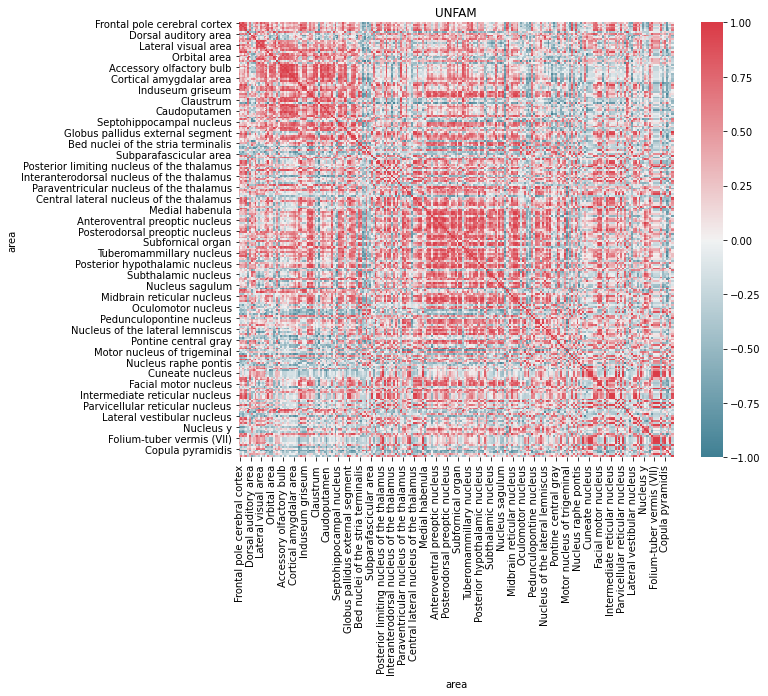

In [28]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [30]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [31]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)

In [32]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [33]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,0.000559649
Medial amygdalar nucleus,0.00324817
Ventral premammillary nucleus,0.00489551
Vascular organ of the lamina terminalis,0.0442113
Cortical amygdalar area,0.0446423
Posterior limiting nucleus of the thalamus,0.0614864
Parastrial nucleus,0.0689416
Anterior tegmental nucleus,0.0706299
Visceral area,0.0715739


In [34]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,0.000628472
Posterior amygdalar nucleus,0.00150287
Ventral premammillary nucleus,0.00166973
Bed nucleus of the anterior commissure,0.00728896
Accessory olfactory bulb,0.02418
Copula pyramidis,0.0251698
Piriform-amygdalar area,0.0310171
Septohippocampal nucleus,0.0339648
Cortical amygdalar area,0.0347258


In [35]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nucleus of the anterior commissure,0.00105443
Paraventricular hypothalamic nucleus descending division,0.0168042
Septohippocampal nucleus,0.0300569
Dorsal auditory area,0.0384712
Posterior hypothalamic nucleus,0.0456246
Superior colliculus sensory related,0.0496222
Reticular nucleus of the thalamus,0.0546294
Ventral part of the lateral geniculate complex,0.0593362
Caudoputamen,0.0612184


## Mann-Whitney Test across groups

In [36]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')

In [37]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [53]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:40].set_index('area')

,pval_Control_vs_Fam
area,
Efferent cochlear group,0.00405656
Intercollicular nucleus,0.00405656
Retroethmoid nucleus,0.00405656
Substantia nigra lateral part,0.00405656
Posterior amygdalar nucleus,0.00405656
Lateral tegmental nucleus,0.00405656
Pontine reticular nucleus ventral part,0.00405656
Superior salivatory nucleus,0.00405656
Granular lamina of the cochlear nuclei,0.00405656


In [55]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:50].set_index('area')

,pval_Control_vs_Unfam
area,
Ventral premammillary nucleus,0.00405656
Retroethmoid nucleus,0.00405656
Lateral tegmental nucleus,0.00405656
Anterior hypothalamic area,0.00405656
Suprachiasmatic preoptic nucleus,0.00405656
Substantia nigra lateral part,0.00405656
Intercollicular nucleus,0.00405656
Granular lamina of the cochlear nuclei,0.00405656
Cochlear nucleus subpedunclular granular region,0.00405656


In [56]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:50].set_index('area')

,pval_Control_vs_Fam
area,
Intercollicular nucleus,0.00405656
Lateral tegmental nucleus,0.00405656
Granular lamina of the cochlear nuclei,0.00405656
Cochlear nucleus subpedunclular granular region,0.00405656
Substantia nigra lateral part,0.00405656
Nucleus z,0.00405656
Accessory abducens nucleus,0.00405656
Efferent vestibular nucleus,0.00405656
Efferent cochlear group,0.00405656


## Calculate cross corr matrix across experimental groups on energy

In [41]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

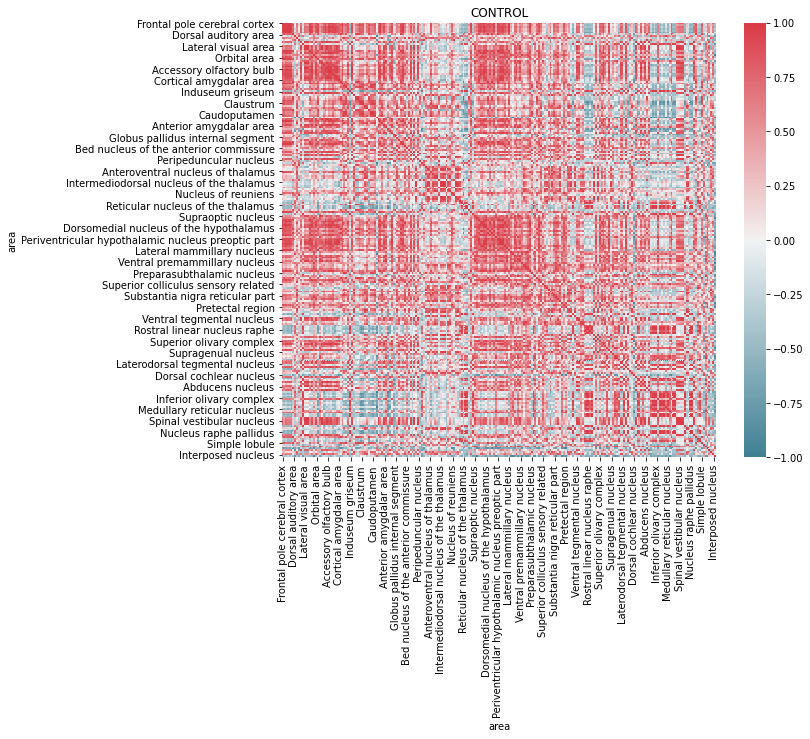

In [42]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

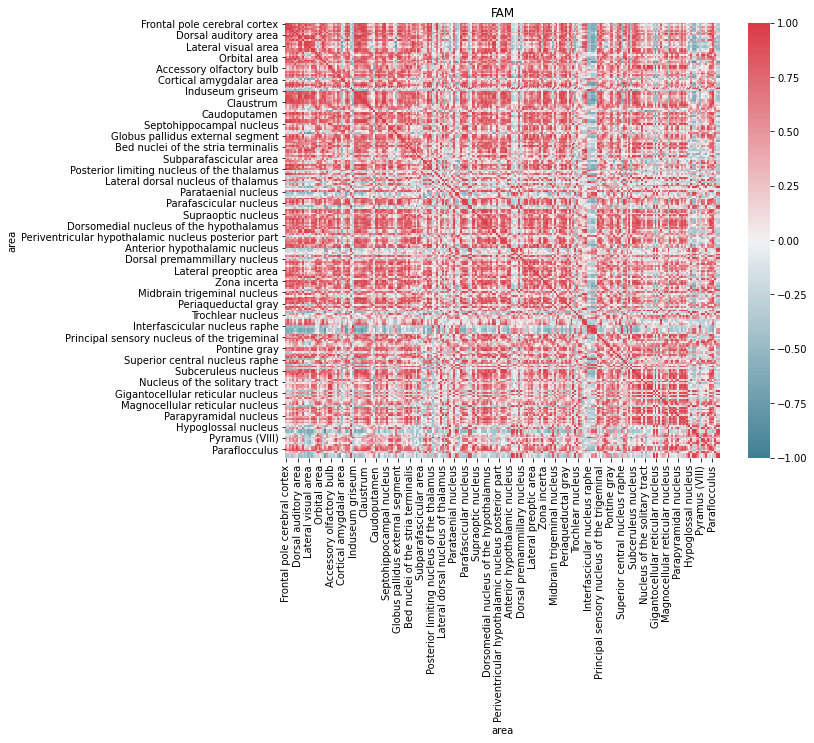

In [43]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

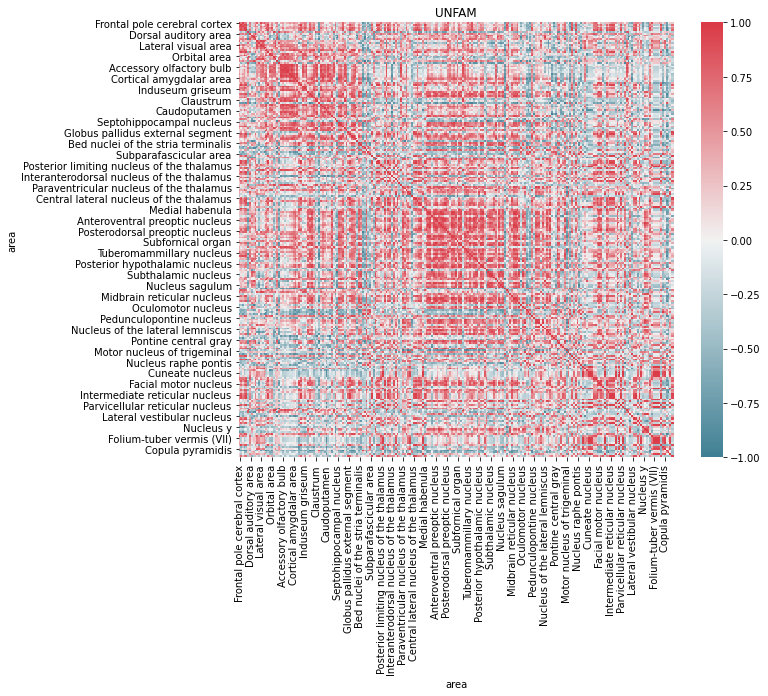

In [44]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')